In [1]:
#!/usr/bin/python
# -*- coding: GBK -*-
%matplotlib inline
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

In [2]:
# Convenience functions for working with colour ramps and bars
def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

In [3]:
shp = fiona.open('DEU_adm_shp/DEU_adm2.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1]) # lower-left
ur = (bds[2], bds[3]) # upper-right
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
print(coords)
print('w = {}, h = {}'.format(w, h))

[5.8662505149842445, 47.27012252807623, 15.041815757751458, 55.05652618408205]
w = 9.175565242767213, h = 7.786403656005824


In [4]:
m = Basemap(
    projection='tmerc',
    lon_0 = (coords[0] + coords[2])/2,
    lat_0 = (coords[1] + coords[3])/2,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra + 0.05 * w,
    llcrnrlat=coords[1] - extra - 0.00 * h,
    urcrnrlon=coords[2] + extra + 0.05 * w,
    urcrnrlat=coords[3] + extra - 0.00 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

(403,
 5,
 [5.8662505149842445, 47.27012252807623, 0.0, 0.0],
 [15.041815757751458, 55.05652618408205, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x11fee47f0>)

/Users/ZHU/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


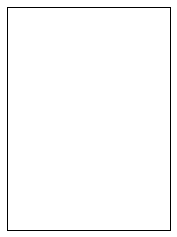

In [5]:
m.readshapefile(
    'DEU_adm_shp/DEU_adm2',
    name='germany',
    color='none',
    zorder=2)

In [6]:
# set up a map dataframe for China
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.germany],
    'region_name': [region['CCA_2'] for region in m.germany_info]})
df_map = df_map[df_map.region_name !=  b'                                                                                                                                                                                                                                                              ']
df_map.region_name = df_map.region_name.astype('int')
df_map['poly_area_m2'] = df_map['poly'].map(lambda x: x.area)
df_map['poly_area_km2'] = df_map['poly_area_m2'] / 1000000
df_map['poly_area_100km2'] = df_map['poly_area_km2'] / 100
df_map['region_area_m2'] = df_map.region_name.apply(df_map.groupby('region_name').sum().poly_area_m2.get_value)
df_map['region_area_km2'] = df_map['region_area_m2'] / 1000000
df_map['region_area_100km2'] = df_map['region_area_km2'] / 100

In [7]:
df_establishment = pd.read_csv('count_establishment_2006.csv')

In [8]:
df_map = pd.merge(df_map, df_establishment, on='region_name')

In [9]:
df_map['density_m2'] = df_map['count'] / df_map['region_area_m2']
df_map['density_km2'] = df_map['count'] / df_map['region_area_km2']
df_map['density_100km2'] = df_map['count'] / df_map['region_area_100km2']
# it's easier to work with NaN values when classifying
# df_map.replace(to_replace={'density_m2': {0: np.nan}, 'density_km2': {0: np.nan},
#                'density_100km2': {0: np.nan}}, inplace=True)

In [10]:
df_map_temp = df_map

In [11]:
df_map = df_map_temp

In [12]:
# # Calculate Jenks natural breaks for density
# breaks = nb(
#     df_map[df_map['density_100km2'].notnull()]['density_100km2'].values,
#     initial=300,
#     k=5)
# # the notnull method lets us match indices when joining
# jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_100km2'].notnull()].index)
# df_map = df_map.join(jb)
# df_map.jenks_bins.fillna(-1, inplace=True)
# jenks_labels = ["<= {:d} establishments per 100 km$^2$".format(int(b)) for b in breaks.bins]
# # jenks_labels.insert(0, 'No region (%s regions)' % len(df_map[df_map['density_km'].isnull()]))

In [13]:
print(min(list(df_map['density_100km2'].values)))
print(max(list(df_map['density_100km2'].values)))

1.62218619807
119.189968786


In [14]:
# User-defined jenks bins
def self_categorize(entry, breaks):
    for i in range(0, len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return 0

breaks = [0., 4., 8., 16., 48., 128.] + [1e20]
df_map['jenks_bins'] = df_map['density_100km2'].apply(self_categorize, args=(breaks,))
jenks_labels = ["<= {:d} establishments per 100 km$^2$".format(int(perc)) for perc in breaks[1:-1]]

print(jenks_labels)

['<= 4 establishments per 100 km$^2$', '<= 8 establishments per 100 km$^2$', '<= 16 establishments per 100 km$^2$', '<= 48 establishments per 100 km$^2$', '<= 128 establishments per 100 km$^2$']


In [15]:
print(min(list(df_map['jenks_bins'].values)))
print(max(list(df_map['jenks_bins'].values)))

0
4


/Users/ZHU/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


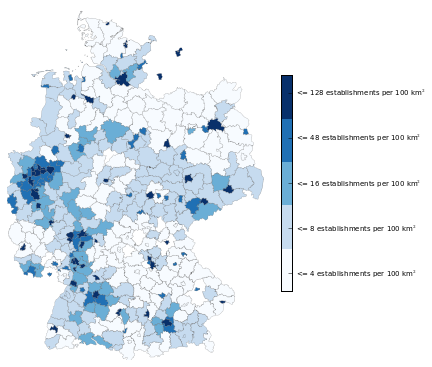

In [16]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
# http://matplotlib.org/examples/color/colormaps_reference.html
cmap = plt.get_cmap('Blues')

# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=0.75, zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=7)

# # Show highest densities, in descending order
# highest = '\n'.join(
#     value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
# highest = 'Most Dense Region:\n' + highest

# # Subtraction is necessary for precise y coordinate alignment
# details = cb.ax.text(
#     -1., 0 - 0.007,
#     highest,
#     ha='right', va='bottom',
#     size=5,
#     color='#555555')

# Bin method, copyright and source data info
smallprint = ax.text(
    1.08, 0.12,
    ' ',
    ha='left', va='bottom',
    size=7,
    color='#555555',
    transform=ax.transAxes)

m.scatter(
    [geom.x for geom in []],
    [geom.y for geom in []],
    15, marker='o', lw=.5,
    facecolor='grey', edgecolor='w',
    alpha=1.0, antialiased=True,
    label='Density of establishment-level observations in 2006', zorder=3, ax=ax,)

# # Draw a map scale
# m.drawmapscale(coords[0] + 0.08, coords[1] + -0.01,
#     (coords[0] + coords[2])/2, (coords[1] + coords[3])/2, length = 2000.,
#     fontsize=6, barstyle='fancy', labelstyle='simple',
#     fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
#     zorder=0, ax=ax,)

# ax.set_title('Density of establishments in 2006\nby Landkreise and Stadtkreise')

# this will set the image width
plt.tight_layout()
fig.set_size_inches(6, 6.5)
plt.savefig('establishment_2006.png', dpi=200, alpha=True)
plt.show()